In [604]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


In [605]:
def plot_train_test_cv(X, y_solution, X_train, y_train, X_test, y_test, X_cv, y_cv, model=None):
    fig, ax = plt.subplots(figsize=(4, 4))

    ax.plot(X, y_solution, color = "black", label="solution", lw=0.8)
    if model is not None:
        x = np.linspace(0, int(X.max()), 100)
        ax.plot(x, model.predict(x), color = "green", label="predicted", lw=0.8)

    ax.scatter(X_train, y_train, color='red', marker='o', label='train')
    ax.scatter(X_test, y_test, color='blue', marker='o', label='test')
    ax.scatter(X_cv, y_cv, color='yellow', marker='o', label='cv')

    ax.set_title("Train, test, cv sets")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()

    plt.show()

In [606]:
def plot_train_test(X, y_solution, X_train, y_train, X_test, y_test, model=None):
    fig, ax = plt.subplots(figsize=(4, 4))

    ax.plot(X, y_solution, color = "black", label="solution", lw=0.8)
    if model is not None:
        x = np.linspace(0, int(X.max()), 100)
        ax.plot(x, model.predict(x), color = "green", label="predicted", lw=0.8)

    ax.scatter(X_train, y_train, color='red', marker='o', label='train')
    ax.scatter(X_test, y_test, color='blue', marker='o', label='test')

    ax.set_title("Train, test sets")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()

    plt.show()

In [607]:
def plot_error_to_param(params, optimal_param, train_errors, val_errors, param_label, param_name):
    fig, ax = plt.subplots(figsize=(4, 4))

    ax.plot(params, train_errors, color='red', marker='o', label='train errors', lw=0.8)
    ax.plot(params, val_errors, color='blue', marker='o', label='val errors', lw=0.8)
    ax.axvline(optimal_param, color='black', label=param_label, lw=0.5)

    ax.set_title("Error vs " + param_name)
    ax.set_xlabel(param_name)
    ax.set_ylabel('error')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    if param_name == 'lambda':
        ax.set_xscale('log')

    plt.show()

In [608]:
def generate_data(m: int):
    X = np.linspace(0, 49, m)
    np.random.seed(2)
    y_solution = X ** 2
    y_custom = y_solution + y_solution * (np.random.sample((m, )) - 0.5)
    return X, y_custom, y_solution

In [609]:
class CustomLinearRegression:
    def __init__(self, degree: int, alpha: float = 0):
        self.model = Ridge(alpha=alpha) if alpha != 0 else LinearRegression()
        self.poly = PolynomialFeatures(degree=degree, include_bias=False)
        self.scaler = StandardScaler()
    
    def fit(self, X_train: np.array, y_train: np.array):
        X_train_modified = self.poly.fit_transform(X_train.reshape(-1, 1))
        X_train_modified_scaled = self.scaler.fit_transform(X_train_modified)
        self.model.fit(X_train_modified_scaled, y_train)
    
    def predict(self, X: np.array) -> np.array:
        X_modified = self.poly.transform(X.reshape(-1, 1))
        X_modified_scaled = self.scaler.transform(X_modified)
        return self.model.predict(X_modified_scaled)
    
    def mse(self, y, y_pred):
        return np.sum((y - y_pred) ** 2) / len(y)



Data

In [610]:
X, y, y_solution = generate_data(18)

In [611]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

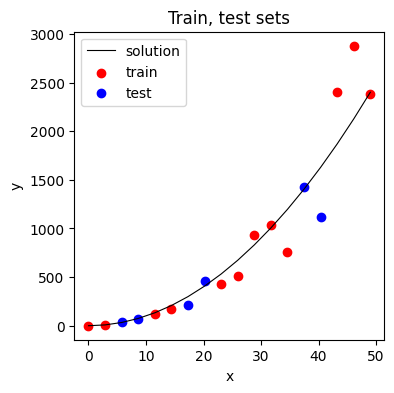

In [612]:
plot_train_test(X, y_solution, X_train, y_train, X_test, y_test)

Train basic model

In [613]:
degree = 10
model = CustomLinearRegression(degree=degree)

model.fit(X_train=X_train, y_train=y_train)

y_pred = model.predict(X_train)
err_train = model.mse(y_pred=y_pred, y=y_train)

y_pred = model.predict(X_test)
err_test = model.mse(y_pred=y_pred, y=y_test)

Analazying results

In [614]:
print(f'{err_train = }, {err_test = }')

err_train = 236.76555431365838, err_test = 698836.7815867242


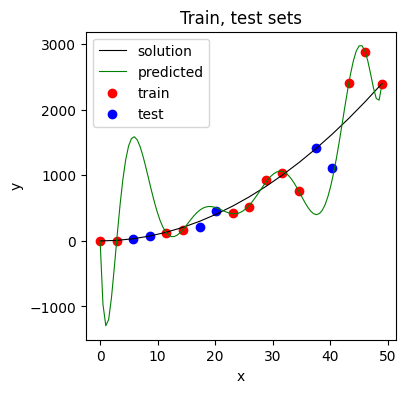

In [615]:
plot_train_test(X, y_solution, X_train, y_train, X_test, y_test, model)

The model is overfitting; has high variance and performs poorly on test items.

Introduce validation set.

In [616]:
X, y, y_solution = generate_data(50)
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=1)

print(f'{X_train.shape = }, {X_test.shape = }, {X_cv.shape = }')

X_train.shape = (30,), X_test.shape = (10,), X_cv.shape = (10,)


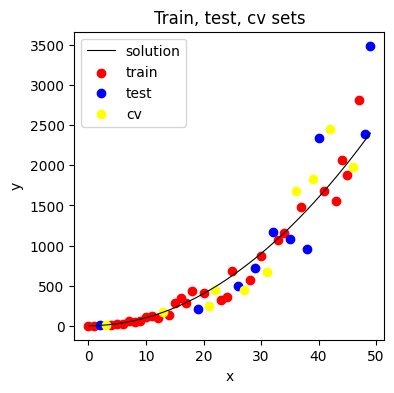

In [617]:
plot_train_test_cv(X, y_solution, X_train, y_train, X_test, y_test, X_cv, y_cv)

Finding optimal degree:

In [618]:
max_degree = 9

train_errors = []
val_errors = []
fitted_models = []

for degree in range(max_degree):
    model = CustomLinearRegression(degree=degree+1)
    model.fit(X_train=X_train, y_train=y_train)
    fitted_models.append(model)

    train_errors.append(model.mse(y_pred=model.predict(X_train), y=y_train))
    val_errors.append(model.mse(y_pred=model.predict(X_cv), y=y_cv))
        
optimal_degree = np.argmin(val_errors) + 1

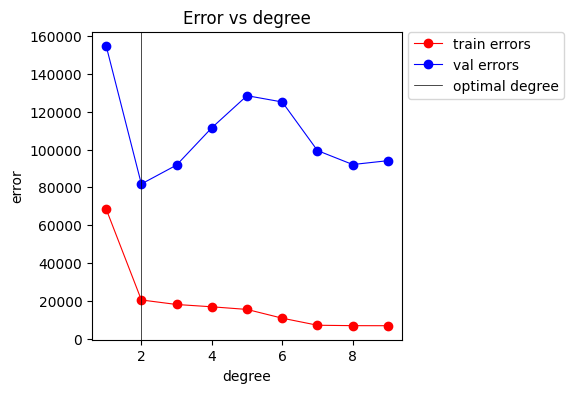

In [619]:
degrees = list(range(1, max_degree + 1))
plot_error_to_param(degrees, optimal_degree ,train_errors, val_errors, param_label='optimal degree', param_name='degree')
    

- the error on the trained data decreases as the model complexity increases
- the error on the cv data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data.

Predicted results.

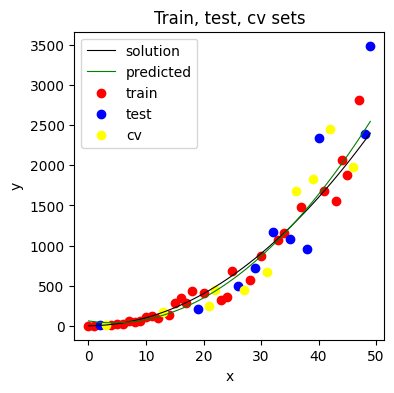

In [620]:
plot_train_test_cv(X, y_solution, X_train, y_train, X_test, y_test,  X_cv, y_cv, fitted_models[optimal_degree - 1])

Improving regularization.

In [621]:
lambda_params = np.array([0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
degree = 20

train_errors = []
val_errors = []
fitted_models = []

for lambda_ in lambda_params:
    model = CustomLinearRegression(degree=degree, alpha=lambda_)
    model.fit(X_train=X_train, y_train=y_train)
    fitted_models.append(model)

    train_errors.append(model.mse(y_pred=model.predict(X_train), y=y_train))
    val_errors.append(model.mse(y_pred=model.predict(X_cv), y=y_cv))
        
optimal_lambda = lambda_params[np.argmin(val_errors)]
print(f'{optimal_lambda = }')

optimal_lambda = 0.001


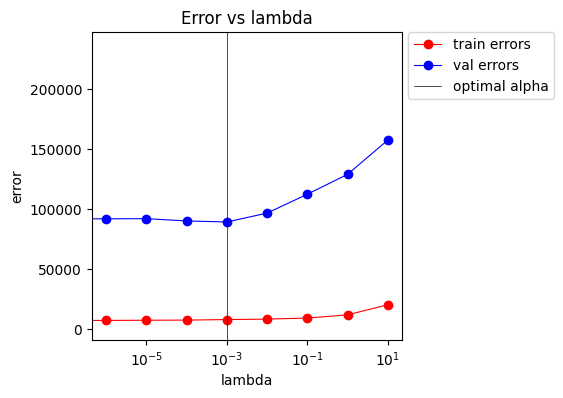

In [622]:
plot_error_to_param(lambda_params, optimal_lambda, train_errors, val_errors, param_label='optimal alpha', param_name='lambda')

As regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model.

Increaing set size to reduce overfitting:

optimal_size = 1000


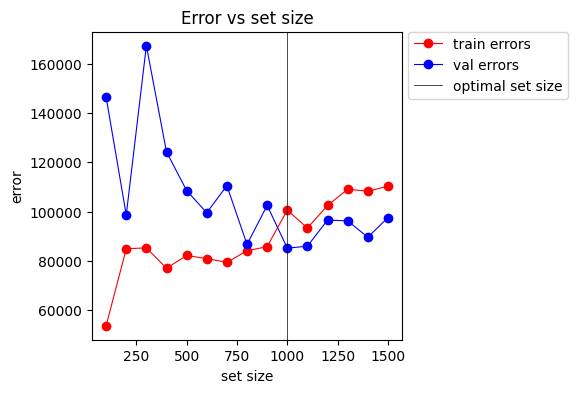

In [623]:
m = 100
m_range = np.array(m * np.arange(1,16))

fitted_models = []
val_errors = []
train_errors = []

for m in m_range:
    X, y, y_solution = generate_data(m)
    X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=1)
    X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=1)

    model = CustomLinearRegression(degree=10)
    model.fit(X_train=X_train, y_train=y_train)
    fitted_models.append(model)

    train_errors.append(model.mse(y_pred=model.predict(X_train), y=y_train))
    val_errors.append(model.mse(y_pred=model.predict(X_cv), y=y_cv))
        
optimal_size = m_range[np.argmin(val_errors)]
print(f'{optimal_size = }')

plot_error_to_param(m_range, optimal_size, train_errors, val_errors, param_label='optimal set size', param_name='set size')

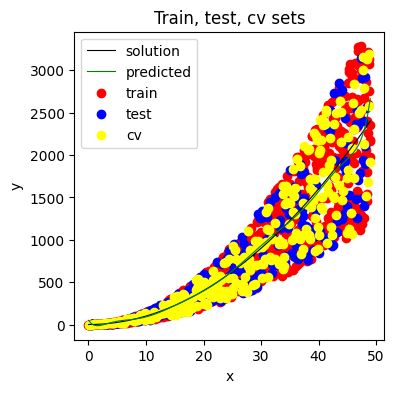

In [624]:
plot_train_test_cv(X, y_solution, X_train, y_train, X_test, y_test,  X_cv, y_cv, fitted_models[np.argmin(val_errors)])

Adding more examples tends to improve generalization (when model overfits).